In [2]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler


In [3]:
stockdata = yf.download('AAPL', start='2018-01-01', end='2020-12-12')
stockdata.head()



[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.950489,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.943363,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.133549,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.601856,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.447342,82271200


Text(0, 0.5, 'prices($)')

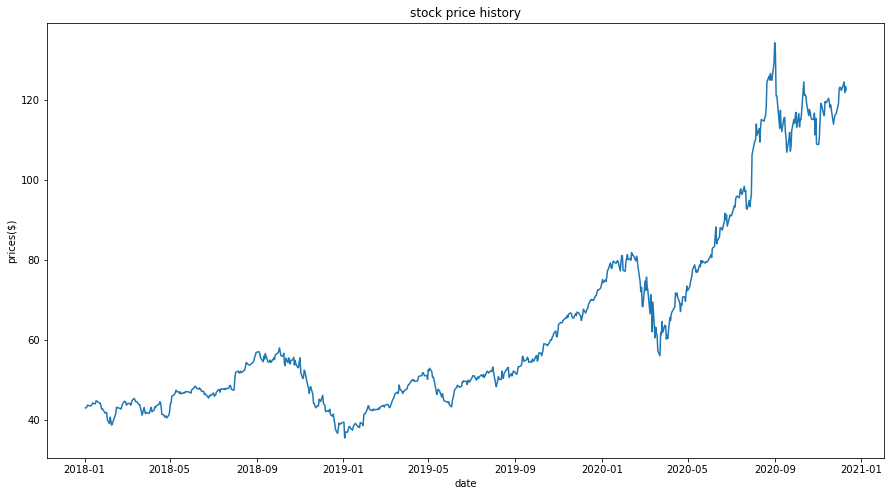

In [4]:
plt.figure(figsize=(15,8))
plt.title('stock price history')
plt.plot(stockdata['Close'])
plt.xlabel('date')
plt.ylabel('prices($)')

In [5]:
closesprice = stockdata['Close']
values = closesprice.values
trainingdatalen = math.ceil(len(values)*0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaleddata = scaler.fit_transform(values.reshape(-1,1))
traindata = scaleddata[0: trainingdatalen, :]

xtrain = []
ytrain = []
for i in range(60, len(traindata)):
    xtrain.append(traindata[i-60:i,0])
    ytrain.append(traindata[i,0])
    
xtrain, ytrain = np.array(xtrain) , np.array(ytrain)
xtrain = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1],1))


In [6]:
testdata = scaleddata[trainingdatalen-60:,:]
xtest = []
ytest = values[trainingdatalen:]

for i in range(60, len(testdata)):
    xtest.append(testdata[i-60:i, 0])
    
xtest = np.array(xtest)    
xtest = np.reshape(xtest, (xtest.shape[0], xtest.shape[1], 1))

In [7]:
model = keras.Sequential()
model.add(layers.LSTM(100,return_sequences=True,
            input_shape=(xtrain.shape[1],1)))
model.add(layers.LSTM(100,return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(xtrain,ytrain, batch_size=1, epochs=3)


Epoch 1/3
535/535 [==============================] - 10s 13ms/step - loss: 0.0012
Epoch 2/3
535/535 [==============================] - 7s 13ms/step - loss: 7.0239e-04
Epoch 3/3
535/535 [==============================] - 7s 13ms/step - loss: 6.4157e-04


In [9]:
predictions = model.predict(xtest)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - ytest)**2)
rmse

5/5 [==============================] - 1s 10ms/step


3.065259211772197

C:\Users\Yaser\AppData\Local\Temp\ipykernel_1220\1708426177.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


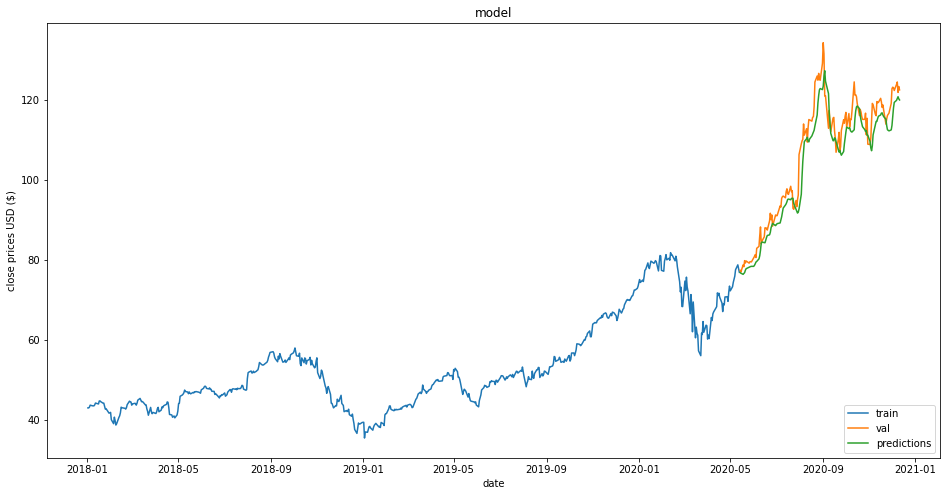

,Close
Date,
2018-01-02,43.064999
2018-01-03,43.057499
2018-01-04,43.257500
2018-01-05,43.750000
2018-01-08,43.587502
...,...
2020-12-07,123.750000
2020-12-08,124.379997
2020-12-09,121.779999


In [12]:
data = stockdata.filter(['Close'])
train = data[:trainingdatalen]
validation = data[trainingdatalen:]

validation['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('model')
plt.xlabel('date')
plt.ylabel('close prices USD ($)')
plt.plot(train)
plt.plot(validation[['Close','Predictions']])
plt.legend(['train','val','predictions'], loc='lower right')
plt.show()
data
